# Recommender System using ALS for implicit Feedback

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext('local')
spark = SparkSession(sc)



## Parsing the Data

In [136]:
import gzip
from ast import literal_eval
import simplejson
import json
import pandas as pd
def parse(filename):
    f = open(filename, 'r')
    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    yield entry


for e in parse("Cell_Phones_&_Accessories.txt"):
    a = simplejson.dumps(e)
    a = literal_eval(a)
    df = pd.DataFrame(a, index=[1,])
    break;

i=0
for e in parse("Cell_Phones_&_Accessories.txt"):
    i+=1
    b = simplejson.dumps(e)
    b = literal_eval(b)

    b = pd.DataFrame(b, index=[1,])
    df = df.append(b, ignore_index=True)
    if i==1000:
        break;
df.to_csv('ratings.csv', index=False)


In [137]:
df = pd.read_csv('ratings.csv')
df.head(3)

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...


In [138]:
#encoding products Ids
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['product/productId'])
le.classes_
df['product/productId'] = le.transform(df['product/productId'])

#encoding users Ids

le = preprocessing.LabelEncoder()
le.fit(df['review/userId'])
le.classes_
df['review/userId'] = le.transform(df['review/userId'])


In [16]:
pd.read_csv('ratings.csv').shape[0]

1001

## Load Data in Spark

In [5]:
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


In [6]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [75]:
ratings = spark.read.load('ratings.csv', format='csv', header=True, inferSchema=True)

In [82]:
ratings.show()

+---+-----------------+--------------------+-------------+-------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|_c0|product/productId|       product/title|product/price|review/userId|  review/profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+---+-----------------+--------------------+-------------+-------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|  0|               76|Mobile Action MA7...|      unknown|          202|             A. Igoe|               0/0|         1.0| 1233360000|          Don't buy!|First of all, the...|
|  1|               76|Mobile Action MA7...|      unknown|          202|             A. Igoe|               0/0|         1.0| 1233360000|          Don't buy!|First of all, the...|
|  2|               76|Mobile Action MA7...|      unknown|          734|        Steven Martz|       

### What are the ratings

In [83]:
print('Distinct values of ratings:')
print(sorted(ratings.select('review/score').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[' and Roll!"""', '0/0', '1.0', '1/3', '13/14', '2.0', '3.0', '4.0', '5.0', '9/9']


### What is minimum number of ratings per user and minimum number of ratings per movie?

In [84]:
tmp1 = ratings.groupBy("review/userid").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("product/title").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1


### What is the total number of users in the data sets?

In [85]:
tmp = ratings.select('review/userid').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 965 distinct users in the data sets


### What is the total number of movies in the data sets?

In [86]:
tmp = ratings.select('product/productid').distinct().count()
print('We have a total of {} distinct products in the data sets'.format(tmp))

We have a total of 94 distinct products in the data sets


### How many movies are rated by users? List movies not rated yet?

### create a temp SQL table view for easier query

In [87]:
ratings.createOrReplaceTempView("ratings")
print('List product that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT `product/productid`, `product/title`"
    "FROM ratings "
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List product that are not rated yet: 
+-----------------+--------------------+
|product/productid|       product/title|
+-----------------+--------------------+
|               76|Mobile Action MA7...|
|               76|Mobile Action MA7...|
|               76|Mobile Action MA7...|
|               76|Mobile Action MA7...|
|               43|USB Data Cable fo...|
|               43|USB Data Cable fo...|
|               43|USB Data Cable fo...|
|               43|USB Data Cable fo...|
|               43|USB Data Cable fo...|
|               43|USB Data Cable fo...|
+-----------------+--------------------+
only showing top 10 rows



In [7]:
# File location and type
file_location = "ratings.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)
rating_data = df.rdd

header = rating_data.take(1)[0]

rating_data = rating_data \
    .filter(lambda line: line!=header) \
    .map(lambda x: list(x))\
    .map(lambda x: (int(x[3]), int(x[0]), x[6].split('/')[0])) \
    .filter(lambda x: x[2]!=' and Roll!"""') \
    .map(lambda x: (x[0], x[1], float(x[2])))\
    .cache()
    
rating_data.take(6)

[(202, 76, 1.0),
 (202, 76, 1.0),
 (734, 76, 5.0),
 (398, 76, 4.0),
 (316, 43, 4.0),
 (857, 43, 1.0)]

## Our implemention of the ALS algorithm in Spark

In [54]:
from __future__ import print_function

import sys

import numpy as np
from numpy.random import rand
from numpy import matrix
from pyspark.sql import SparkSession


In [71]:
#Annex functions
def set_data_matrix(M, data_list = None):
    for data in data_list:
        M[data[0], data[1]] = data[2]
    return M

def update(i, mat, ratings): #i = x, mat = V if caculate U, rating is M.
    uu = mat.shape[0]
    ff = mat.shape[1]

    XtX = mat.T * mat    #projection matrix
    Xty = mat.T * ratings[i, :].T

    for j in range(ff):
        XtX[j, j] += LAMBDA * uu

    return np.linalg.solve(XtX, Xty)
def rmse(R, ms, us):
    diff = R - ms * us.T
    return np.sqrt(np.sum(np.power(diff, 2)) / (M * U)
                  )



In [72]:
spark = SparkSession\
        .builder\
        .appName("PythonALS")\
        .getOrCreate()

sc = spark.sparkContext

In [80]:
rating_list

[(202, 76, 1.0),
 (202, 76, 1.0),
 (734, 76, 5.0),
 (398, 76, 4.0),
 (316, 43, 4.0),
 (857, 43, 1.0),
 (343, 43, 4.0),
 (283, 43, 5.0),
 (779, 43, 1.0),
 (503, 43, 3.0),
 (658, 43, 4.0),
 (769, 43, 1.0),
 (196, 43, 5.0),
 (155, 62, 4.0),
 (951, 62, 5.0),
 (158, 62, 5.0),
 (442, 62, 1.0),
 (964, 62, 3.0),
 (493, 58, 5.0),
 (502, 42, 5.0),
 (198, 50, 5.0),
 (131, 50, 4.0),
 (551, 59, 5.0),
 (512, 80, 5.0),
 (659, 1, 4.0),
 (964, 0, 1.0),
 (964, 0, 4.0),
 (964, 0, 2.0),
 (964, 0, 4.0),
 (765, 3, 4.0),
 (964, 3, 4.0),
 (317, 2, 5.0),
 (736, 2, 5.0),
 (942, 2, 4.0),
 (368, 2, 5.0),
 (114, 2, 4.0),
 (49, 2, 1.0),
 (226, 2, 1.0),
 (624, 2, 3.0),
 (533, 2, 5.0),
 (521, 2, 5.0),
 (159, 2, 4.0),
 (433, 2, 1.0),
 (515, 2, 4.0),
 (74, 2, 3.0),
 (104, 2, 3.0),
 (606, 2, 4.0),
 (461, 2, 5.0),
 (893, 2, 4.0),
 (804, 2, 5.0),
 (766, 2, 5.0),
 (643, 2, 5.0),
 (890, 2, 5.0),
 (211, 2, 1.0),
 (549, 2, 5.0),
 (444, 2, 5.0),
 (730, 2, 1.0),
 (37, 2, 4.0),
 (807, 2, 5.0),
 (212, 2, 5.0),
 (177, 2, 5.0),
 (1

In [79]:
rating_list = rating_data.take(1000)
LAMBDA = 0.01   # regularization


M = pd.read_csv('ratings.csv').shape[0] #users 
U = pd.read_csv('ratings.csv').shape[0] #items
F = 10 #latent vector    
num_iters = 10
partitions = 2

R = np.full((M, U), 0, dtype=np.float64)
R = matrix(set_data_matrix(R, rating_list)) #M

users = matrix(np.full((M, F), 1.0)) #U users matrix
product = matrix(np.full((U, F), 1.0))    #V product matrix

Rb = sc.broadcast(R)
users_b = sc.broadcast(users)
product_b = sc.broadcast(product)

for i in range(num_iters):
    users = sc.parallelize(range(M), partitions) \
           .map(lambda x: update(x, product_b.value, Rb.value)) \
           .collect() #U, x= row number
    # collect() returns a list, so array ends up being
    # a 3-d array, we take the first 2 dims for the matrix
    users = matrix(np.array(users)[:, :, 0]) #U
    users_b = sc.broadcast(users)

    product = sc.parallelize(range(U), partitions) \
           .map(lambda x: update(x, users_b.value, Rb.value.T)) \
           .collect() #V, x = columns
    product = matrix(np.array(product)[:, :, 0])
    product_b = sc.broadcast(product)

    error = rmse(R, users, product)
    print("Iteration %d:" % i)
    print("R= %s:" % (str(R))) 
    print("ms= %s:" % (str(users)))   
    print("us= %s:" % (str(product)))           
    #print("\nRMSE: %5.4f\n" % error)
    print("RMSE=%.4f" % error)


Iteration 0:
R= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]:
ms= [[0.000499  0.000499  0.000499  ... 0.000499  0.000499  0.000499 ]
 [0.0002994 0.0002994 0.0002994 ... 0.0002994 0.0002994 0.0002994]
 [0.000499  0.000499  0.000499  ... 0.000499  0.000499  0.000499 ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]:
us= [[0.00199366 0.00199366 0.00199366 ... 0.00199366 0.00199366 0.00199366]
 [0.00015949 0.00015949 0.00015949 ... 0.00015949 0.00015949 0.00015949]
 [0.03289547 0.03289547 0.03289547 ... 0.03289547 0.03289547 0.03289547]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0

Iteration 7:
R= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]:
ms= [[1.27548342e-14 1.27548353e-14 1.27548361e-14 ... 1.27548369e-14
  1.27548400e-14 1.27548379e-14]
 [1.15442225e-01 1.15442225e-01 1.15442225e-01 ... 1.15442225e-01
  1.15442225e-01 1.15442225e-01]
 [3.57268991e-13 3.57269087e-13 3.57269107e-13 ... 3.57269109e-13
  3.57269182e-13 3.57269127e-13]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]:
us= [[1.17727384e-02 1.17727384e-02 1.17727384e-02 ... 1.17727384e-02
  1.17727384e-02 1.17727384e-02]
 [1.00624249e-18 1.00624445e-18 1.00624458e-18 ... 1.00624459e-18
  1.00624568e-18 1.00624489e-18]
 [2.13182049e+00 2.1

## Spark ALS using the existing pyspark library

### ALS model selection and evaluation¶

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
ratings = spark.createDataFrame(rating_data)
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="_1", itemCol="_2", ratingCol="_3",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.2262151345541294


DataFrame[summary: string, id: string]

In [180]:
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

In [185]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            als = ALS(maxIter=num_iters, regParam=reg, userCol="_1", itemCol="_2", ratingCol="_3",
              coldStartStrategy="drop")
            model = als.fit(training)
            # make prediction
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [186]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 3.6661299397570164
8 latent factors and regularization = 0.01: validation RMSE is 3.0578709309114234
8 latent factors and regularization = 0.05: validation RMSE is 2.9508510292628465
8 latent factors and regularization = 0.1: validation RMSE is 2.987582167522112
8 latent factors and regularization = 0.2: validation RMSE is 3.01865631487051
10 latent factors and regularization = 0.001: validation RMSE is 3.6661299397570164
10 latent factors and regularization = 0.01: validation RMSE is 3.0578709309114234
10 latent factors and regularization = 0.05: validation RMSE is 2.9508510292628465
10 latent factors and regularization = 0.1: validation RMSE is 2.987582167522112
10 latent factors and regularization = 0.2: validation RMSE is 3.01865631487051
12 latent factors and regularization = 0.001: validation RMSE is 3.6661299397570164
12 latent factors and regularization = 0.01: validation RMSE is 3.0578709309114234
12 latent factor

### ALS Model Learning curve

In [189]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        als = ALS(maxIter=num_iters, regParam=reg, userCol="_1", itemCol="_2", ratingCol="_3",
          coldStartStrategy="drop")
        model = als.fit(training)
        # make prediction
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                            predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        errors.append(rmse)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

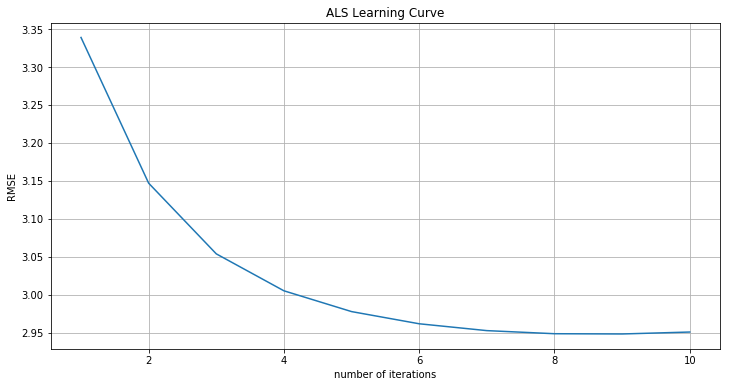

In [190]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

### Model testing

In [192]:
# Evaluate the final model by computing the RMSE on the test data
predictions = final_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="_3",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 2.9508510292628465
